### What is Routing in LangGraph?

Routing in LangGraph refers to the ability to conditionally determine which node to execute next based on the current state or the output of a node. This is typically implemented using:

* **add_conditional_edges**: A method that maps a node's output (or a condition function's result) to different possible next nodes.
* **State**: The workflow's state can store variables that influence routing decisions.
* **Condition Functions**: Functions that evaluate the state or node output to decide the next step.

### Key Concepts

* **Dynamic Flow**: Unlike a linear sequence, routing lets the graph adapt to intermediate results.
* **Condition Logic**: You define rules (e.g., "if this, go here; if that, go there").
* **Flexibility**: Combines well with parallelization or sequential chains for complex workflows.

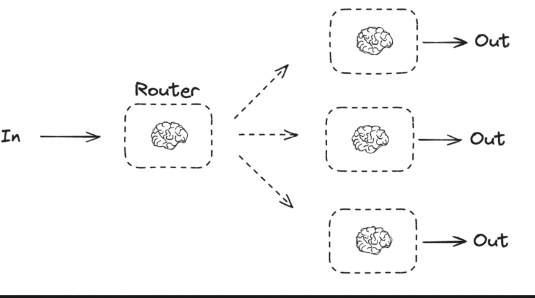

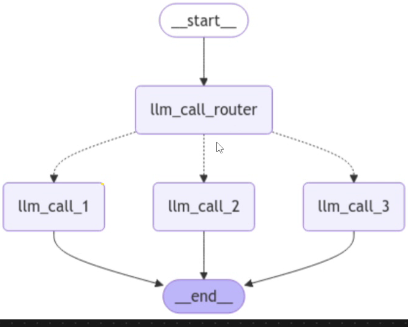

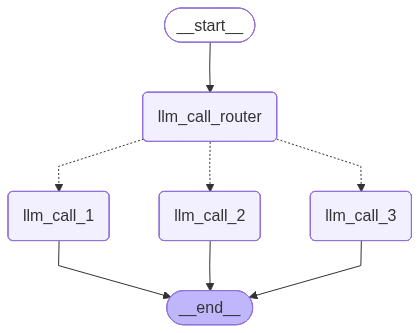

In [11]:
# 🔧 1. Imports and Environment Setup
import os
from dotenv import load_dotenv
load_dotenv()
# •	Loads environment variables (e.g., API keys) from a .env file, so we don’t hardcode sensitive data.

# 🔐 2. Setting the API Key
from langchain_groq import ChatGroq

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
# •	You're using Groq's language model (Qwen).
# •	This line sets the GROQ API key so the model can authenticate and work.

# 🧠 3. Initialize the Language Model (LLM)
llm = ChatGroq(model="llama-3.3-70b-versatile")
result = llm.invoke("Hello")
result
# AIMessage(content='Hello. How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 36, 'total_tokens': 46, 'completion_time': 0.009000735, 'prompt_time': 0.018498203, 'queue_time': 0.050751327, 'total_time': 0.027498938}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_2ddfbb0da0', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--78b77071-bb50-46f0-b731-502c697cc6fe-0', usage_metadata={'input_tokens': 36, 'output_tokens': 10, 'total_tokens': 46})

# •	llm is your chat model.
# •	You test it by asking "Hello" and get a response.

# 🧭 4. Routing Schema Definition
from typing_extensions import Literal
from pydantic import BaseModel, Field

class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(description="The next step in the routing process")
# 📝 This ensures:
# LlM can only return "poem", "story", or "joke". Anything else = ❌ Error
# 🧠 This is used for structured output using pydantic.

#🧠 5. Wrap LLM to Output in This Format
router = llm.with_structured_output(Route)
# •	This tells the model: “When you answer, follow this format using the Route schema.”
# 📍 Now llm_router can only return one of the 3 allowed values: "poem", "story", or "joke".

#📦 6. State Definition
from typing_extensions import TypedDict
class State(TypedDict):
    input: str
    decision: str
    output: str
#•	This defines the data that will be passed between each step in the workflow.


#⚙️ 7. Define the Action Nodes
#Story Generator
def llm_call_1(state: State):
    result = llm.invoke(state["input"])
    return {"output": result.content}
#Joke Generator
def llm_call_2(state: State):
    print("LLM call 2 is called")
    result = llm.invoke(state["input"])
    return {"output": result.content}
#Poem Generator
def llm_call_3(state: State):
    result = llm.invoke(state["input"])
    return {"output": result.content}
# •	These are three separate LLM calls based on what the user wants:
# o	If it's a story, call llm_call_1
# o	If it's a joke, call llm_call_2
# o	If it's a poem, call llm_call_3

#🧭 8. Router Function
from langchain_core.messages import HumanMessage, SystemMessage
def llm_call_router(state: State):
    decision = router.invoke([
        SystemMessage(content="Route the input to story, joke, or poem based on the user's request"),
        HumanMessage(content=state["input"])
    ])
    return {"decision": decision.step}
# •	This function uses the LLM to decide what the user is asking for:
# o	It sends a system instruction and the user input.
# o	The model replies with "poem", "story", or "joke".
# 🧠 This router checks the input, then returns: "poem" or "story" or "joke"


#🔁 9. Decision Logic
def route_decision(state: State):
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"
# ✅ This tells LangGraph:
# If decision is story → go to lm_call_1
# If joke → go to lm_call_2
# If poem → go to lm_call_3

#🧱 10. Create Workflow Graph
from langgraph.graph import StateGraph, START, END
#•	A LangGraph workflow is a directed graph of steps.

#Build the graph
router_builder = StateGraph(State)

#Add nodes (steps)
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

#Add edges (connections)
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    }
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)
# •	This connects the steps together:
# o	First, input goes to llm_call_router.
# o	Based on routing decision, it goes to the correct node.
# o	After that node, the workflow ends.

# ✅ 11. Compile and Run the Workflow
from IPython.display import Image, display
router_workflow = router_builder.compile()
# Optional: Show a visual of the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))






In [ ]:
#🚀 12. Use the Workflow
state = router_workflow.invoke({"input": "Write me a joke about Agentic AI System"})
print(state["output"])
# LLM call 2 is called
# Why did the Agentic AI System go to therapy?
# Because it was struggling to "agent" change in its life, and its goals were no longer "aligned" with its programming! (get it?)
                                                                                                                       


LLM call 2 is called
Why did the Agentic AI System go to therapy?

Because it was struggling to "agent" change in its life, and its goals were no longer "aligned" with its programming! (get it?)
